In [1]:
import gammapy
if (gammapy.__version__ != "0.17"):
    print("Not sure it will work, use Gammapy 0.17 !")
    
codefolder = "../" 
import sys
sys.path.append(".") 
sys.path.append(codefolder)

# Analysis SoHAPPy datasets
Create dummy datasets and tune the analysis and plot tools for the complete analysis.  
An other notebook is devoted to the analysis of stacked datasets

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.time          import Time
from astropy.visualization import quantity_support

#from gammapy.utils.random import get_random_state
from gammapy.maps import RegionNDMap, MapAxis
from gammapy.modeling.models import TemplateSpectralModel, SkyModel

# from gammapy.datasets import SpectrumDataset, Datasets, SpectrumDatasetOnOff
from gammapy.datasets import Datasets
from gammapy.estimators import FluxPointsEstimator
from gammapy.modeling import Fit

from dataset_tools import generate_dataset, check_datasets, check_dataset, get_masked_dataset
#from dataset_plot import extracted_spectrum, counts_versus_time, flux_versus_time, stackedcounts_versus_time, lightcurve, plot_count, plot_residual
import dataset_plot as dplt
# plt.style.use('seaborn-talk')
plt.style.use('seaborn-poster')




# Create dummy datasets

### Theoretical fluxes

In [3]:
def create_fluxes(norms,indices,
                  Emin=15*u.GeV, Emax=405*u.TeV,nbin=40,
                  scale=1,
                  Eref=1000*u.GeV,flux_unit="1/(cm2 GeV s)",
                  debug=False):

    e_unit = Emin.unit
    
    # classgammapy.maps.MapAxis(nodes, interp='lin', name='', node_type='edges', unit='')
    Eflux = MapAxis.from_edges(np.logspace(np.log10(Emin.value),
                                           np.log10(Emax.to(e_unit).value),nbin),name="Eflux",unit=e_unit) # Flux points
    
    dfdE = []
    for norm,index in zip(norms,indices):
            dfdE.append(scale*norm*(Eflux.center/Eref)**index*u.Unit(flux_unit))
            
    if (debug):
        fig,ax = plt.subplots(figsize=(3,3))
        with quantity_support():
            for f in dfdE:
                ax.plot(Eflux.center,f)
                ax.scatter(Eflux.center,f,marker="x")
        ax.set_yscale("log")
        ax.set_xscale("log")
        
    return Eflux, dfdE

<Quantity [1.50000000e+01, 1.94856982e+01, 2.53128289e+01, 3.28825429e+01,
           4.27159537e+01, 5.54900120e+01, 7.20841083e+01, 9.36406118e+01,
           1.21643513e+02, 1.58020585e+02, 2.05276095e+02, 2.66663202e+02,
           3.46407911e+02, 4.50000000e+02, 5.84570945e+02, 7.59384866e+02,
           9.86476286e+02, 1.28147861e+03, 1.66470036e+03, 2.16252325e+03,
           2.80921835e+03, 3.64930539e+03, 4.74061756e+03, 6.15828286e+03,
           7.99989607e+03, 1.03922373e+04, 1.35000000e+04, 1.75371283e+04,
           2.27815460e+04, 2.95942886e+04, 3.84443583e+04, 4.99410108e+04,
           6.48756975e+04, 8.42765506e+04, 1.09479162e+05, 1.42218527e+05,
           1.84748486e+05, 2.39996882e+05, 3.11767120e+05, 4.05000000e+05] GeV>

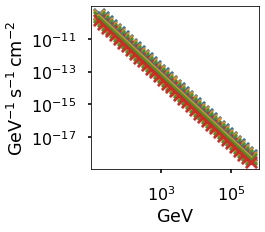

In [4]:
nfluxes = 4
norms   = [10e-13, 8e-13, 6e-13, 4e-13, ]
indices = nfluxes*[-2]
scale = 0.1
Eflux, dfdE_list = create_fluxes(norms,indices,scale=scale,debug=True)
Eflux.edges

### IRFs, E ranges, observing duration

In [5]:
#Erange = [ [10*u.GeV, 160*u.GeV], [70*u.GeV, 220*u.GeV], [100*u.GeV, 500*u.GeV], [200*u.GeV, 500*u.GeV]]
Erange = [ [20*u.GeV, 400*u.GeV], [20*u.GeV, 400*u.GeV], [20*u.GeV,  400*u.GeV] , [20*u.GeV,  400*u.GeV]]

t0     = Time('2000-01-01 02:00:00',scale='utc')
dt     = [100*u.s, 200*u.s, 300*u.s, 400*u.s]

irfdir = "../../input/irf/Full/prod3-v2/"
irf    = nfluxes*[irfdir + "/South/FullArray/20deg/South_z20_average_100s/irf_file.fits.gz"]

### Generate datasets and create the DATASETS

In [21]:
onoff  = False
tstart = t0
#seed   = 1965
seed   = 2020

dset_list = Datasets()
for i,_ in enumerate(dfdE_list):
    ds = generate_dataset(Eflux.center, dfdE_list[i], Erange=Erange[i],
                          tstart = tstart, tobs = dt[i], irf_file=irf[i], 
                          seed=seed, onoff = onoff, name="DS"+str(i))
    #ds.edisp.peek()
    tstart = tstart + dt[i]
    dset_list.append(ds)

Dataset  DS0
 E reco edges :  [ 30.  60.  90. 120. 150. 180. 210. 240. 270. 300.] GeV
 E true edges :  [ 20.  40.  60.  80. 100. 120. 140. 160. 180. 200. 220. 240. 260.] GeV
 Fluctuations : seed =  2020
Dataset  DS1
 E reco edges :  [ 30.  60.  90. 120. 150. 180. 210. 240. 270. 300.] GeV
 E true edges :  [ 20.  40.  60.  80. 100. 120. 140. 160. 180. 200. 220. 240. 260.] GeV
 Fluctuations : seed =  2020
Dataset  DS2
 E reco edges :  [ 30.  60.  90. 120. 150. 180. 210. 240. 270. 300.] GeV
 E true edges :  [ 20.  40.  60.  80. 100. 120. 140. 160. 180. 200. 220. 240. 260.] GeV
 Fluctuations : seed =  2020
Dataset  DS3
 E reco edges :  [ 30.  60.  90. 120. 150. 180. 210. 240. 270. 300.] GeV
 E true edges :  [ 20.  40.  60.  80. 100. 120. 140. 160. 180. 200. 220. 240. 260.] GeV
 Fluctuations : seed =  2020


In [7]:
ds.info_dict()

{'name': 'DS3',
 'livetime': <Quantity 400. s>,
 'n_on': 5047,
 'background': 4159.903226056023,
 'excess': 887.0967739439767,
 'significance': 13.304090415914448,
 'background_rate': <Quantity 10.39975807 1 / s>,
 'gamma_rate': <Quantity 2.21774193 1 / s>}

### Check that interpolated models follow the initial data points
See Source code for gammapy.modeling.models.spectral, https://docs.gammapy.org/0.17/_modules/gammapy/modeling/models/spectral.html

 Total flux :  6.766219403271274e-09 1 / (cm2 s)
 Energy flux :  1.0420323056157088e-06 GeV / (cm2 s)
 Total flux :  5.41297552261702e-09 1 / (cm2 s)
 Energy flux :  8.336258444925669e-07 GeV / (cm2 s)
 Total flux :  4.059731641962764e-09 1 / (cm2 s)
 Energy flux :  6.252193833694252e-07 GeV / (cm2 s)


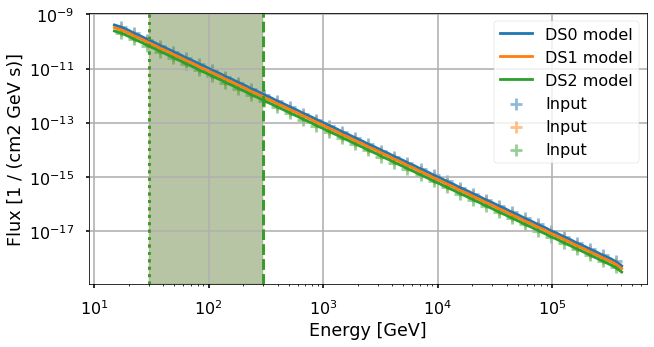

In [8]:
fig, ax  = plt.subplots(figsize=(10,5))
for flux, ds, color in zip(dfdE_list, dset_list, ["tab:blue","tab:orange","tab:green"]):

    with quantity_support():
        # Model associated to dataset
        # Can also try plot_erro with the same arguments
        ds.models[0].spectral_model.plot([min(Eflux.edges),max(Eflux.edges)],
                                         label=ds.name + " model",
                                         ax=ax,
                                         color=color,
                                         energy_unit = "GeV",
                                         flux_unit = "1/ (cm2 s GeV)")
        
        f_total = ds.models[0].spectral_model.integral(min(Eflux.edges),max(Eflux.edges))
        print(" Total flux : ",f_total)
        f_energy = ds.models[0].spectral_model.energy_flux(min(Eflux.edges),max(Eflux.edges))
        print(" Energy flux : ",f_energy)

        ax.scatter(Eflux.center, flux,marker="+",alpha=0.5,label="Input",color=color)
        ax.set_xscale("log")
        ax.axvline(x=ds.energy_range[0],ls=":",color=color)        
        ax.axvline(x=ds.energy_range[1],ls="--",color=color)
        ax.axvspan(xmin=ds.energy_range[0],xmax=ds.energy_range[1],alpha=0.2,color=color)
        ax.grid("both")
        ax.set_yscale("log")
        ax.legend()

# Analyse datasets - energy dependence

### Dataset count numbers and flux values at center of bins

In [9]:
check_datasets(dset_list,deeper=True,masked=False)
#check_datasets(dset_list,deeper=True,masked=True)

 0         DS0    100.00 s    1593.00    1039.98     553.02     579.36   SpecDS0 
    42.4  [   30.0,    60.0]     696.00     536.40     159.60     159.24    1     5.74e-11 
    73.5  [   60.0,    90.0]     317.00     205.93     111.07     119.85    1     1.92e-11 
   103.9  [   90.0,   120.0]     179.00     117.94      61.06      70.69    1     9.43e-12 
   134.2  [  120.0,   150.0]     153.00      68.16      84.84      70.46    1     5.67e-12 
   164.3  [  150.0,   180.0]      88.00      41.58      46.42      58.56    1     3.83e-12 
   194.4  [  180.0,   210.0]      66.00      27.13      38.87      33.58    1     2.71e-12 
   224.5  [  210.0,   240.0]      53.00      18.75      34.25      38.19    1     2.03e-12 
   254.6  [  240.0,   270.0]      28.00      13.66      14.34      19.78    1     1.58e-12 
   284.6  [  270.0,   300.0]      13.00      10.42       2.58       9.02    1     1.27e-12 
 1         DS1    200.00 s    2974.00    2079.95     894.05     926.98   SpecDS1 
    42.4

## Plot excess/expected counts 
Increase scale value to have a perfect match - no error bars are plotted

>>>>>  [[[159.23904 ]]

 [[119.85164 ]]

 [[ 70.68761 ]]

 [[ 70.457985]]

 [[ 58.56344 ]]

 [[ 33.582623]]

 [[ 38.1859  ]]

 [[ 19.7802  ]]

 [[  9.015696]]]
>>>>>  [[[254.78247 ]]

 [[191.76262 ]]

 [[113.100174]]

 [[112.73278 ]]

 [[ 93.70151 ]]

 [[ 53.732193]]

 [[ 61.097443]]

 [[ 31.648317]]

 [[ 14.425113]]]
>>>>>  [[[286.63028]]

 [[215.73294]]

 [[127.2377 ]]

 [[126.82438]]

 [[105.41419]]

 [[ 60.44872]]

 [[ 68.73463]]

 [[ 35.60436]]

 [[ 16.22825]]]
>>>>>  [[[254.78247 ]]

 [[191.76262 ]]

 [[113.100174]]

 [[112.73278 ]]

 [[ 93.70151 ]]

 [[ 53.732193]]

 [[ 61.097443]]

 [[ 31.648317]]

 [[ 14.425113]]]


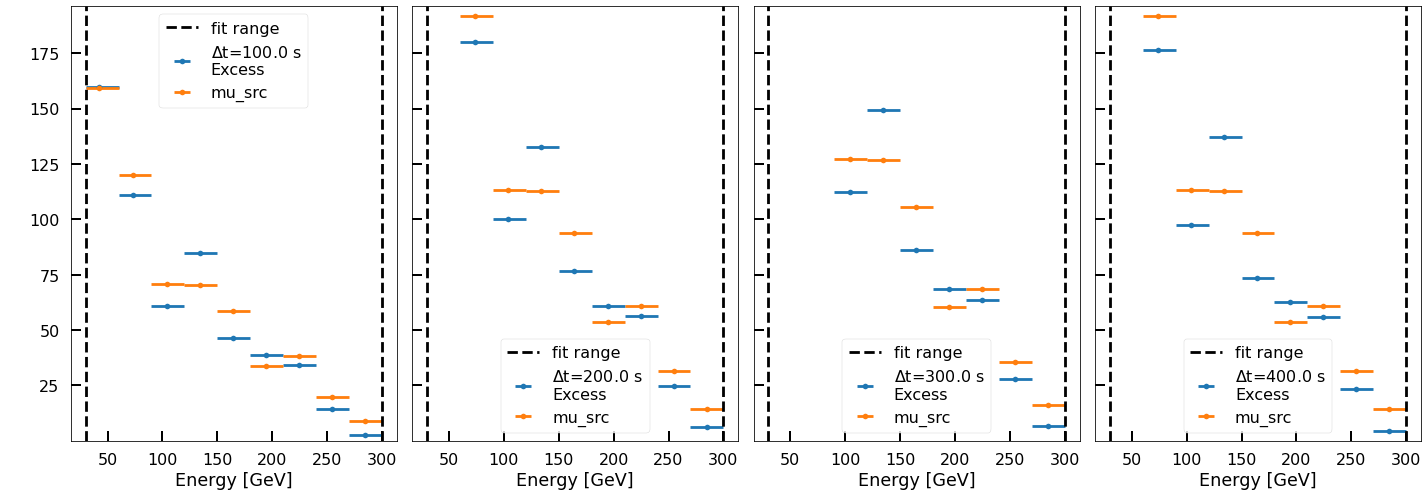

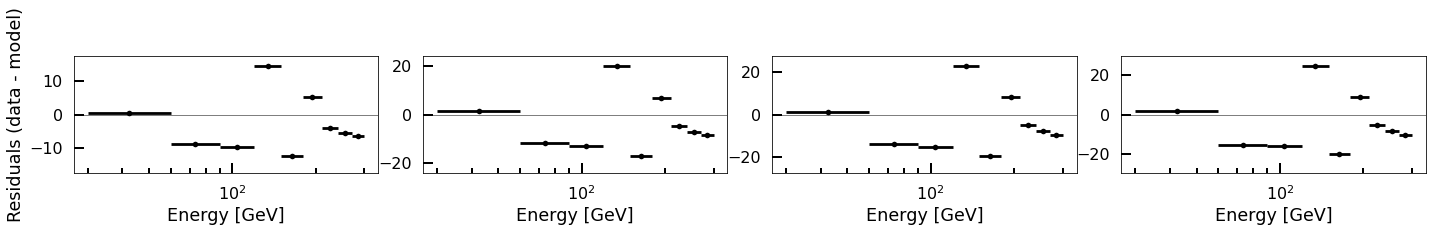

In [10]:
#plot_panel(dset_list,plot_count,fixrange=True,ysize=5,nmaxcol=3)
dplt.panels(dset_list, dplt.excess_counts, fixrange=True,ysize=7,nmaxcol=4,xscale="linear",yscale="linear")
dplt.panels(dset_list, dplt.residuals, ysize=3, nmaxcol=4,yscale="linear")

## Extract the flux from the count numbers

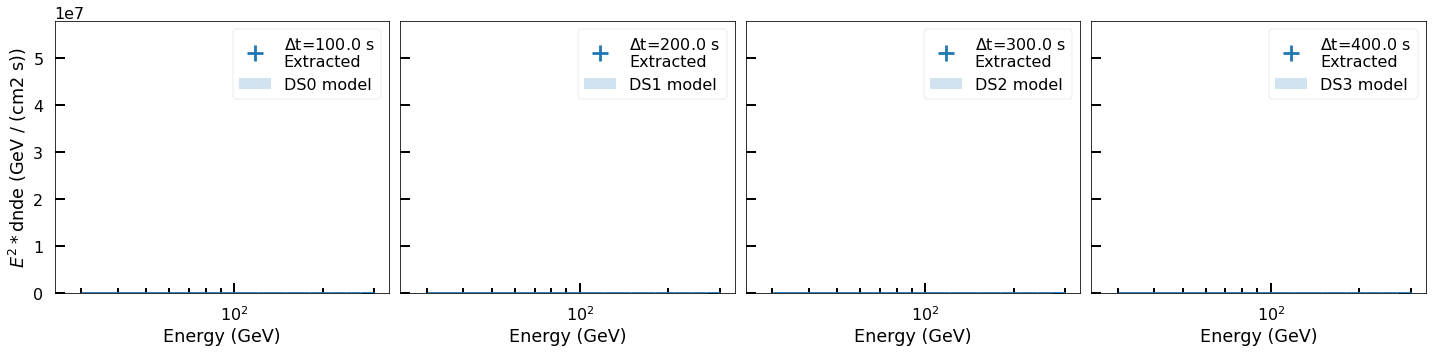

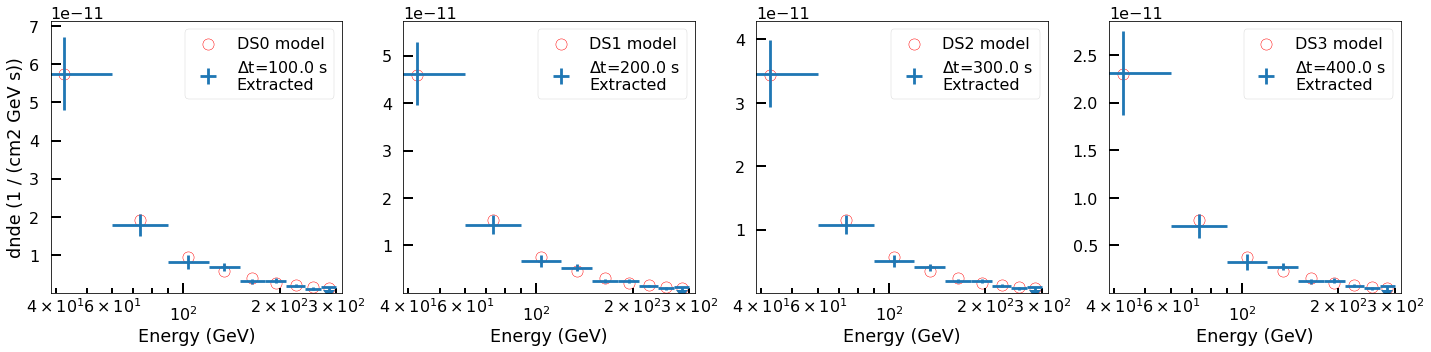

In [11]:
#plot_panel(dset_list,nmaxcol=3, xsize=5, ysize=7, fixrange = True, func=plot_extracted_spectrum,index=2,style="bar")
dplt.panels(dset_list,nmaxcol=4, xsize=8, ysize=5, fixrange = True, yscale="linear",func=dplt.extracted_spectrum,index=2,style="bar")
dplt.panels(dset_list,nmaxcol=4, xsize=8, ysize=5, fixrange = False, yscale="linear",func=dplt.extracted_spectrum,index=0,style="scatter")

# Analysis datasets - time evolution

### Excess counts

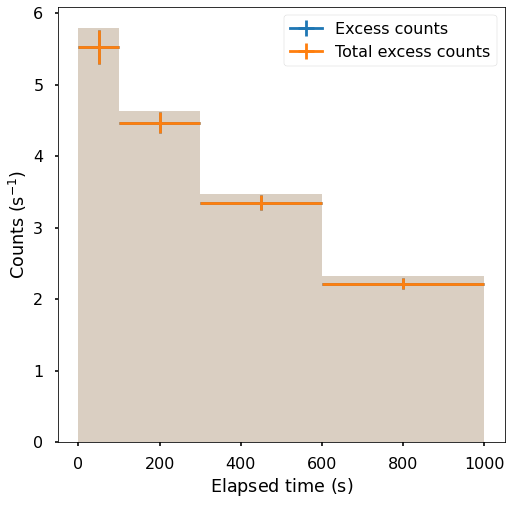

In [12]:
fig,ax = plt.subplots(figsize=(8,8))
dplt.excess_versus_time(dset_list, ax = ax, rate=True, unmasked=True)

## Flux
The variation of the flux with time is subject to the evolution of energy for each time slice.
Computing the mean value is very much sensitive to the boundares and is dommainted by the first energy bins.
As a consequence it is preferable to compute the energy flux, E*dndE

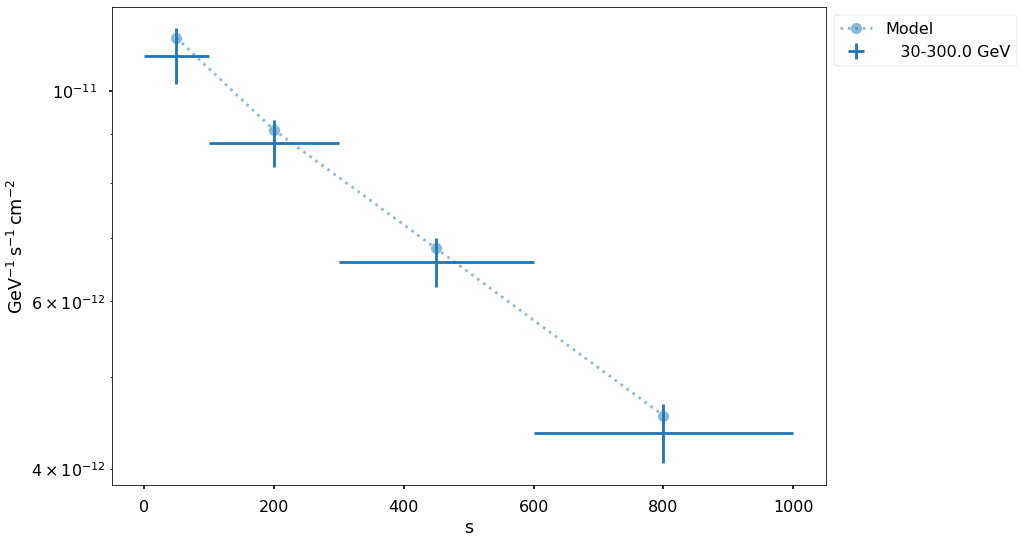

In [13]:
# Plot the flux time evolution for a give range (limited to the reco axis range)
ax = dplt.flux_versus_time(dset_list, emin=10*u.GeV, emax=1000*u.GeV,
                     style="line",
                     color="tab:blue",debug=False)
ax.set_yscale("log")

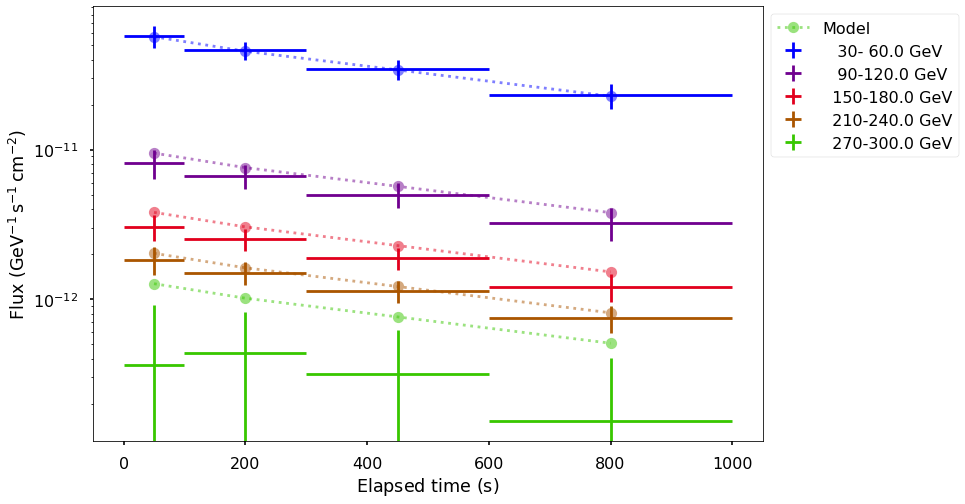

In [14]:
# Plot the flux time evolution fr a series of energy ranges 
dplt.fluxes_versus_time(dset_list,nstep=2,debug=False)

## Light curve simulation

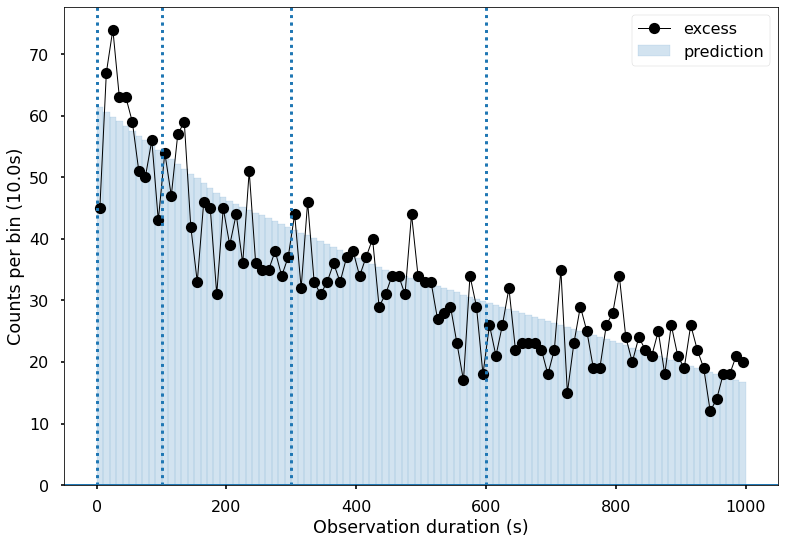

In [15]:
ax = dplt.lightcurve(dset_list,tag="excess",style="line",binwidth=10*u.s)
dplt.lightcurve(dset_list,tag="prediction",style="bar",color="tab:blue",alpha=0.2,ax=ax,binwidth=10*u.s)

# Check cumulated statistics
Note that flux stacking is not possible form the dataset stacking methods

In [16]:
from dataset_tools import stacking
dset_stacked = stacking(dset_list)

## Cumulated counts

In [17]:
check_datasets(dset_stacked,masked=False,deeper=True)

 0    1st unmasked    100.00 s    1593.00    1039.98     553.02     579.36   SpecDS0 
    42.4  [   30.0,    60.0]     696.00     536.40     159.60     159.24    1     5.74e-11 
    73.5  [   60.0,    90.0]     317.00     205.93     111.07     119.85    1     1.92e-11 
   103.9  [   90.0,   120.0]     179.00     117.94      61.06      70.69    1     9.43e-12 
   134.2  [  120.0,   150.0]     153.00      68.16      84.84      70.46    1     5.67e-12 
   164.3  [  150.0,   180.0]      88.00      41.58      46.42      58.56    1     3.83e-12 
   194.4  [  180.0,   210.0]      66.00      27.13      38.87      33.58    1     2.71e-12 
   224.5  [  210.0,   240.0]      53.00      18.75      34.25      38.19    1     2.03e-12 
   254.6  [  240.0,   270.0]      28.00      13.66      14.34      19.78    1     1.58e-12 
   284.6  [  270.0,   300.0]      13.00      10.42       2.58       9.02    1     1.27e-12 
 1    Stacked_DS1    300.00 s    4567.00    3119.93    1447.07    1738.09   SpecDS0 
 

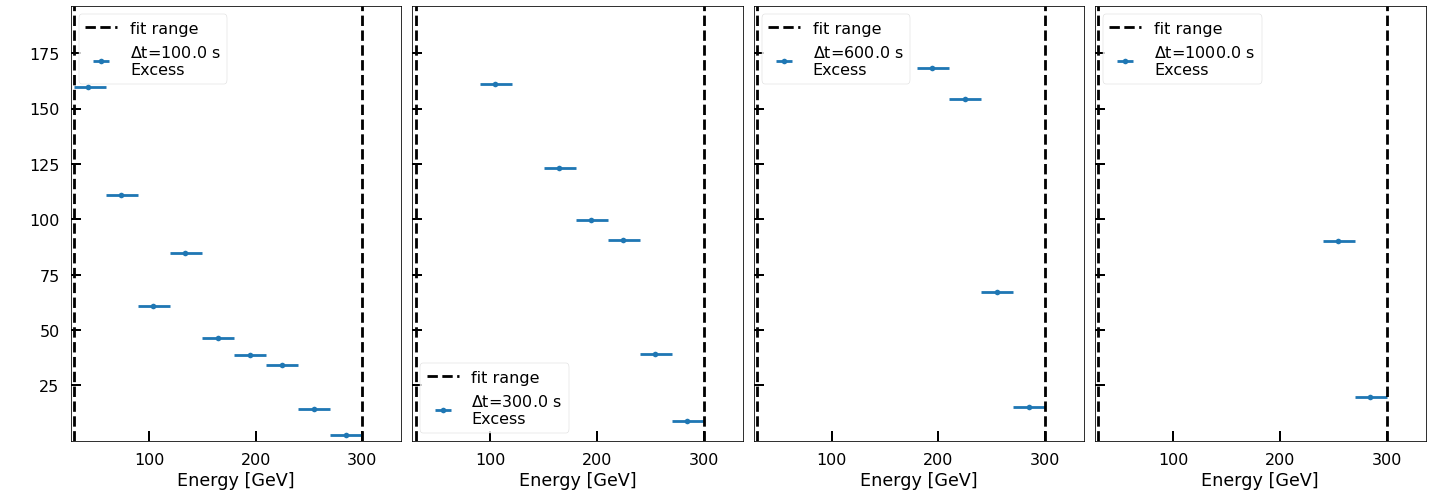

In [18]:
dplt.panels(dset_stacked,dplt.excess_counts,fixrange=True,ysize=7,nmaxcol=4,xscale="linear",yscale="linear",stacked=True)
# residuals have no sense here !

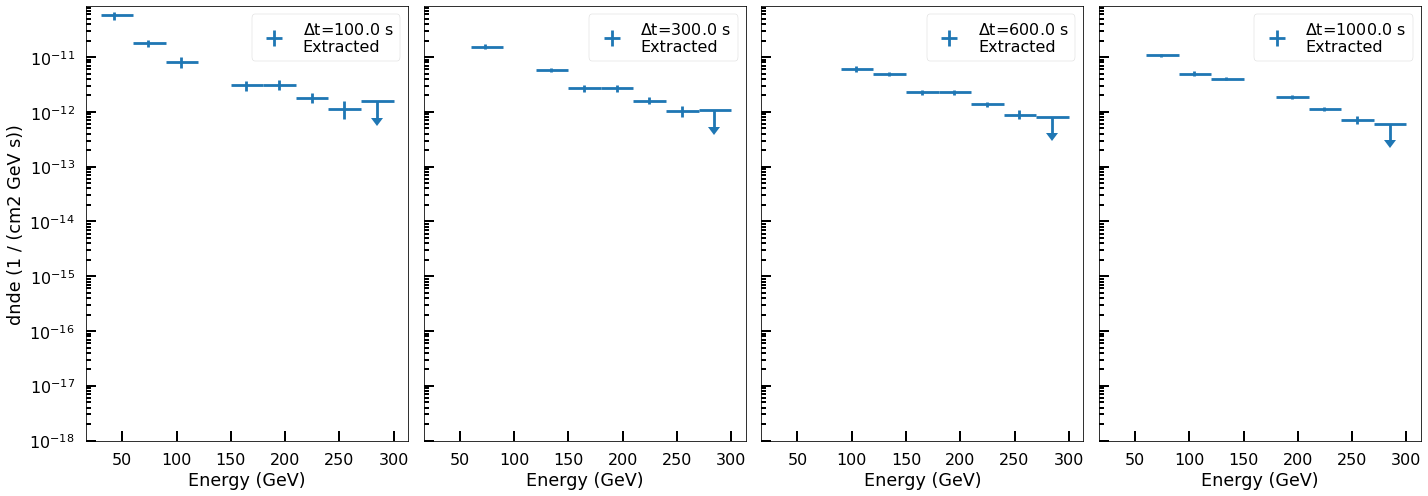

In [19]:
dplt.panels(dset_stacked,dplt.extracted_spectrum,
           fixrange=True,ysize=7,nmaxcol=4,xscale="linear",yscale="log",theory=True)

## Cumulated counts versus time

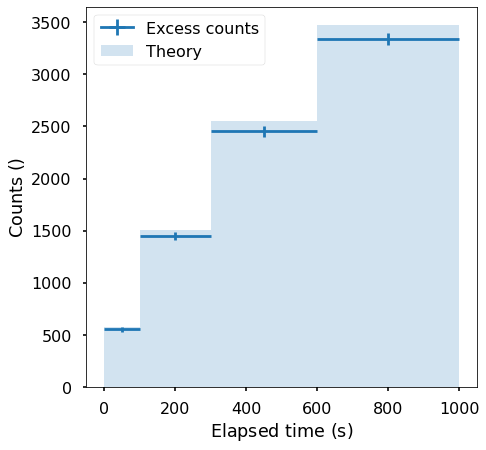

In [20]:
dplt.stacked_versus_time(dset_stacked,dsets=dset_list, rate=False)